# Implementing a Declarative Node using the `ddn.basic.node` Module

In this notebook we demonstrate how to implement a declarative node using the `ddn.basic.node` module. This will allow us to explore the behavior of the node and solve simple bi-level optimization problems. For more sophisticated problems and integrating into a large deep learning model `ddn.pytorch` modules should be used instead.

We consider the problem of minimizing the KL-divergence between the input $x$ and output $y$ subject to the output forming a valid probablility vector (i.e., the elements of $y$ be positive and sum to one). We will assume strictly positive $x$. The problem can be written formally as

$$
\begin{array}{rll}
y =& \text{argmin}_u & - \sum_{i=1}^{n} x_i \log u_i \\
& \text{subject to} & \sum_{i=1}^{n} u_i = 1
\end{array}
$$
where the posivity constraint on $y$ is automatically satisfied by the domain of the log function.

A nice feature of this problem is that we can solve it in closed-form as
$$
y = \frac{1}{\sum_{i=1}^{n} x_i} x.
$$

However, we will only use this for verification and pretend for now that we do not have a closed-form solution. Instead we will make use of the `scipy.optimize` module to solve the problem via an iterative method. Deriving our deep declarative node from the `LinEqConstDeclarativeNode` class, we will need to implement two functions: the `objective` function and the `solve` function (the `constraint` and `gradient` functions are implemented for us).


In [1]:
import numpy as np
import scipy.optimize as opt

import sys
sys.path.append("../")
from ddn.basic.node import *


# create the example node
class MinKLNode(LinEqConstDeclarativeNode):
    def __init__(self, n):
        super().__init__(n, n, np.ones((1,n)), np.ones((1,1)))

    def objective(self, x, u):
        return -1.0 * np.dot(x, np.log(u))
        
    def solve(self, x):
        u0 = np.ones((self.dim_y,)) / self.dim_y
        result = opt.minimize(lambda u: self.objective(x, u), u0,
                              constraints={'type': 'eq', 'fun': lambda u: (np.dot(self.A, u) - self.b)[0]})
        return result.x, None

In [2]:
# test the node
node = MinKLNode(5)
x = np.random.random(5)
print("Input:           {}".format(x))
print("Expected output: {}".format(x / np.sum(x)))

y, _ = node.solve(x)
print("Actual output:   {}".format(y))

Input:           [0.68385288 0.49859997 0.11494326 0.21414186 0.81160261]
Expected output: [0.29436569 0.21462324 0.04947753 0.09217774 0.34935579]
Actual output:   [0.29434945 0.21459548 0.04949067 0.09220775 0.34935665]


C:\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


We now plot the function and gradient sweeping the first component of the input $x_1$ from 0.1 to 10.0 while holding the other values of $x$ constant.

C:\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
..\ddn\basic\node.py:232: UserWarning: optimality check not implemented yet
  warnings.warn("optimality check not implemented yet")


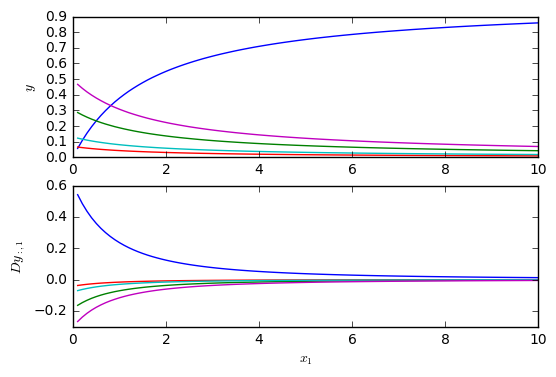

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

x_data = np.linspace(0.1, 10.0, 100)
y_data = []
Dy_data = []
for x[0] in x_data:
    y, _ = node.solve(x)
    y_data.append(y)
    Dy_data.append(node.gradient(x, y)[:,0])
    
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x_data, y_data)
plt.ylabel(r"$y$")

plt.subplot(2, 1, 2)
plt.plot(x_data, Dy_data)
plt.xlabel(r"$x_1$"); plt.ylabel(r"$Dy_{:,1}$")

